# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2

trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    loss = mean + (1-prob)**2
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 1 # Length of the well
n = 2 # Energy level to be found
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 23.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
#params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)
params = optims.adam (grad(objective), params, callback=callback, step_size=0.001, num_iters=5000)

Iteration 0
diffeq = 2326.459183569439 prob = 3.5325060280642115
loss = 2332.8727703516206 E = 23.0
Iteration 100
diffeq = 16.916256213604814 prob = 0.017941090870057574
loss = 17.880695914606306 E = 22.970018270534002
Iteration 200
diffeq = 2.6581761877229115 prob = 0.010730251135489508
loss = 3.636830823741363 E = 22.970760705225796
Iteration 300
diffeq = 1.090422612357696 prob = 0.01266867366265887
loss = 2.0652457603247494 E = 22.970425676114356
Iteration 400
diffeq = 0.8239742638989452 prob = 0.01101203370178172
loss = 1.8020714613816309 E = 22.969957621104847
Iteration 500
diffeq = 0.6105681653859388 prob = 0.009040775735297836
loss = 1.592568349541239 E = 22.96949529162907
Iteration 600
diffeq = 0.4452981677396848 prob = 0.007167916757517991
loss = 1.4310137132552914 E = 22.96906904821441
Iteration 700
diffeq = 0.32427308740030314 prob = 0.005481424706790836
loss = 1.3133402840035378 E = 22.968695972993203
Iteration 800
diffeq = 0.23870585982607662 prob = 0.004032859834786257
lo

# Plots

In [7]:
replot = 0
if replot == 1 :
    params['E'] = initE
    n = 2
    L = 1
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

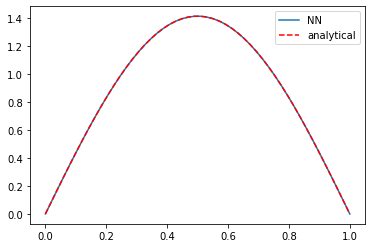

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

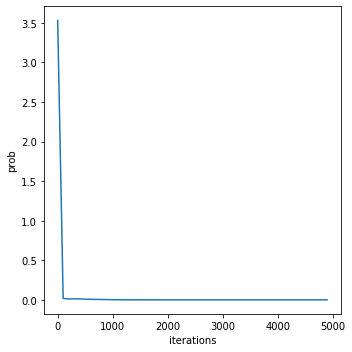

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure (figsize=(5,5))
plt.clf ()

#plt.subplot (1 , 1 , 1)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')


'''

plt.subplot (1, 2, 1)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (1, 2, 2)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
'''


'''
plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

'''

plt.tight_layout()

plt.savefig (name + "_diagProb.png")

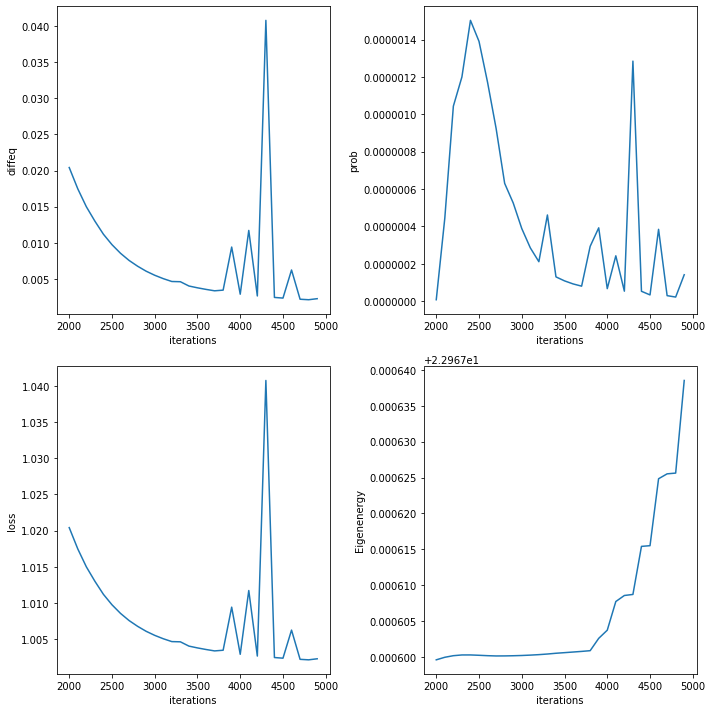

In [10]:
trunc = 20
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

# Write to file

In [11]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8))

    
outfile.write (fstr)
outfile.close ()